In [1]:
from dateutil.parser import parse

import pandas as pd
import datetime
import matplotlib.pyplot as plt

# Получение модели оплаты 2021-2023
Получим цены с [официального сайта](https://www.divvybikes.com/pricing) и соответственно построим тариф:
## Для member пользователей:
- поездки 45- минут на классических велосипедах - бесплатно
- поездки 45+ минут на классических велосипедах - 0.17 доллара за минуты выше тарифа
- поездки на электрических велосипедах - 0.17 доллара за минуту
- **Вне зависимости от поездок** - 130.90 доллара в год

## Для casual пользователей:
- поездки 30- минут на классических велосипедах - бесплатно
- поездки 30+ минут на классических велосипедах - 0.17 доллара за минуты выше тарифа
- поездки на электрических велосипедах - 0.42 доллара за минуту
- **Вне зависимости от длительности и типа велосипеда** - 1 доллар за разблокировку

За потерю велосипеда штраф 1200 долларов

----

Для упрощения расчетов, сделаем следующие предположения:
- Велосипеды, которые не были взяты и были возвращены - найденные велосипеды
- Велосипеды, которые были взяты и не были возвращены - потерянные велосипеды

Тогда количество потерянных велосипедов = потерянные велосипеды - найденные велосипеды.

In [ ]:
result_sums = []

for year in range(2020, 2024):
    df = pd.read_csv(f"data/{year}/Divvy_Trips_{year}_full.csv.gz", compression="gzip")
    df.drop(
        columns=[
            "start_station_id",
            "end_station_id",
            "start_lat",
            "start_lng",
            "end_lat",
            "end_lng",
        ],
        inplace=True,
    )
    # Колонка с длительностью поездки
    df["duration"] = pd.to_datetime(df["ended_at"]) - pd.to_datetime(df["started_at"])
    # Переводим в минуты
    df["duration"] = round(df["duration"].dt.total_seconds().div(60), 1)
    found_df = df[df["start_station_name"].isna()]
    lost_df = df[df["end_station_name"].isna()]
    # Считаем итоговое количество потерянных велосипедов
    lost_bikes = lost_df["ride_id"].count() - found_df["ride_id"].count()
    # Для основного подсчета надо убрать поездки с потерянными/найденными велосипедами
    df = df[df["start_station_name"].notna() & df["end_station_name"].notna()]
    # Разделяем пользователей на категории и считаем превышение тарифа для каждой
    casual_df = df[df["member_casual"] == "casual"]
    member_df = df[df["member_casual"] == "member"]
    casual_df["more_than_30"] = casual_df["duration"].apply(
        lambda x: x - 30 if x > 30 else 0
    )
    member_df["more_than_45"] = member_df["duration"].apply(
        lambda x: x - 45 if x > 45 else 0
    )
    # Считаем доход по категориям
    casual_df["cost"] = casual_df.apply(
        lambda x: 1 + x["duration"] * 0.42
        if x["rideable_type"] == "electric_bike"
        else 1 + x["more_than_30"] * 0.17,
        axis=1,
    )
    member_df["cost"] = member_df.apply(
        lambda x: x["duration"] * 0.17
        if x["rideable_type"] == "electric_bike"
        else x["more_than_45"] * 0.17,
        axis=1,
    )
    # Добавляем результат в список
    result_sums.append(
        (year, casual_df["cost"].sum() + member_df["cost"].sum() + 1200 * lost_bikes)
    )

# Получение модели оплаты 2013-2019
В 2013-2019 были другие тарифы:
>...Usertype: 'Customer' is a rider who purchased a 24-Hour Pass; 'Subscriber' is a rider who purchased an Annual Membership

Исходя из этого и цен на сайте, можно сформировать такой тариф:
## Для customer пользователей:
- поездки до 3 часов на велосипедах - бесплатно
- поездки 3+ часов на велосипедах - 0.17 доллара за минуты выше тарифа
- **Вне зависимости от поездок** - 16.50 долларов за разблокировку

## Для subscriber пользователей:
- поездки до 45 минут на велосипедах - бесплатно
- поездки 45+ минут на велосипедах - 0.17 доллара за минуты выше тарифа
- **Вне зависимости от поездок** - 130.90 доллара в год

**Примечание**: в 2013-2019 не было разделения поездок по типу велосипедов, поэтому предпологаем что все велосипеды были классическими

In [ ]:
for year in range(2013, 2018):
    if year == 2013:
        # В 2013 другое название файла
        df = pd.read_csv("data/2013/Divvy_Trips_2013.csv")
    else:
        df = pd.read_csv(
            f"data/{year}/Divvy_Trips_{year}_full.csv.gz", compression="gzip"
        )
    # Получаем время в минутах
    df["duration"] = round(df["tripduration"].div(60), 1)
    # Отделяем найденные/потерянные велосипеды
    lost_df = df[df["to_station_name"].isna()]
    found_df = df[df["from_station_name"].isna()]
    lost_bikes = lost_df["trip_id"].count() - found_df["trip_id"].count()
    df = df[df["from_station_name"].notna() & df["to_station_name"].notna()]
    # Разделяем пользователей на две категории
    customer_df = df[df["usertype"] == "Customer"]
    member_df = df[df["usertype"] == "Subscriber"]
    # Считаем платные минуты
    customer_df["more_than_3"] = customer_df["duration"].apply(
        lambda x: x - 180 if x > 180 else 0
    )
    member_df["more_than_45"] = member_df["duration"].apply(
        lambda x: x - 45 if x > 45 else 0
    )
    customer_df["cost"] = customer_df["more_than_3"] * 0.17
    member_df["cost"] = member_df["more_than_45"] * 0.17
    # Добавляем результат
    result_sums.append(
        (year, customer_df["cost"].sum() + member_df["cost"].sum() + 1200 * lost_bikes)
    )

In [ ]:
# 2018/2019 с особым форматом, их обрабатываем отдельно
df = pd.read_csv("data/2018/Divvy_Trips_2018_full.csv.gz", compression="gzip")
# Убираем запятые, чтобы починить перевод в float
df["01 - Rental Details Duration In Seconds Uncapped"] = df[
    "01 - Rental Details Duration In Seconds Uncapped"
].replace({",": ""}, regex=True)
df["01 - Rental Details Duration In Seconds Uncapped"] = df[
    "01 - Rental Details Duration In Seconds Uncapped"
].astype(float)
# Продолжительность в минутах
df["duration"] = round(
    df["01 - Rental Details Duration In Seconds Uncapped"].div(60), 1
)
# Отделяем потерянные/найденные велосипеды
lost_df = df[df["02 - Rental End Station Name"].isna()]
found_df = df[df["03 - Rental Start Station Name"].isna()]
lost_bikes = (
    lost_df["01 - Rental Details Rental ID"].count()
    - found_df["01 - Rental Details Rental ID"].count()
)
df = df[
    df["03 - Rental Start Station Name"].notna()
    & df["02 - Rental End Station Name"].notna()
]
# Считаем доход по категориям
customer_df = df[df["User Type"] == "Customer"]
member_df = df[df["User Type"] == "Subscriber"]
customer_df["more_than_3"] = customer_df["duration"].apply(
    lambda x: x - 180 if x > 180 else 0
)
member_df["more_than_45"] = member_df["duration"].apply(
    lambda x: x - 45 if x > 45 else 0
)
customer_df["cost"] = customer_df["more_than_3"] * 0.17
member_df["cost"] = member_df["more_than_45"] * 0.17
# Добавляем результат в список
result_sums.append(
    (2018, customer_df["cost"].sum() + member_df["cost"].sum() + 1200 * lost_bikes)
)

In [ ]:
df = pd.read_csv("data/2019/Divvy_Trips_2019_full.csv.gz", compression="gzip")
# Снова убираем странный формат числа
df["tripduration"] = df["tripduration"].replace({",": ""}, regex=True).astype(float)
df["duration"] = round(df["tripduration"].div(60), 1)
# Отделяем потерянные/найденные велосипеды
lost_df = df[df["to_station_name"].isna()]
found_df = df[df["from_station_name"].isna()]
lost_bikes = lost_df["trip_id"].count() - found_df["trip_id"].count()
df = df[df["from_station_name"].notna() & df["to_station_name"].notna()]
# Считаем доход по категориям
customer_df = df[df["usertype"] == "Customer"]
member_df = df[df["usertype"] == "Subscriber"]
customer_df["more_than_3"] = customer_df["duration"].apply(
    lambda x: x - 180 if x > 180 else 0
)
member_df["more_than_45"] = member_df["duration"].apply(
    lambda x: x - 45 if x > 45 else 0
)
customer_df["cost"] = customer_df["more_than_3"] * 0.17
member_df["cost"] = member_df["more_than_45"] * 0.17
# Добавляем результат в список
result_sums.append(
    (2019, customer_df["cost"].sum() + member_df["cost"].sum() + 1200 * lost_bikes)
)

## Посчитаем доход от подписок

In [3]:
df = pd.read_csv("data/2023/Divvy_Trips_2023_full.csv.gz", compression="gzip")

grouped_by_bike_2023 = df[["start_station_name", "started_at", "member_casual"]]
grouped_by_bike_2023 = grouped_by_bike_2023.rename(
    columns={"start_station_name": "count", "started_at": "start_time"}
)

In [6]:
df = pd.read_csv("data/2022/Divvy_Trips_2022_full.csv.gz", compression="gzip")

grouped_by_bike_2022 = df[["start_station_name", "started_at", "member_casual"]]
grouped_by_bike_2022 = grouped_by_bike_2022.rename(
    columns={"start_station_name": "count", "started_at": "start_time"}
)


df = pd.read_csv("data/2021/Divvy_Trips_2021_full.csv.gz", compression="gzip")

grouped_by_bike_2021 = df[["start_station_name", "started_at", "member_casual"]]
grouped_by_bike_2021 = grouped_by_bike_2021.rename(
    columns={"start_station_name": "count", "started_at": "start_time"}
)


df = pd.read_csv("data/2020/Divvy_Trips_2020_full.csv.gz", compression="gzip")

grouped_by_bike_2020 = df[["start_station_name", "started_at", "member_casual"]]
grouped_by_bike_2020 = grouped_by_bike_2020.rename(
    columns={"start_station_name": "count", "started_at": "start_time"}
)


df = pd.read_csv("data/2019/Divvy_Trips_2019_full.csv.gz", compression="gzip")

grouped_by_bike_2019 = df[["from_station_name", "start_time", "usertype"]]
grouped_by_bike_2019 = grouped_by_bike_2019.rename(
    columns={"from_station_name": "count", "usertype": "member_casual"}
)


df = pd.read_csv("data/2018/Divvy_Trips_2018_full.csv.gz", compression="gzip")

grouped_by_bike_2018 = df[
    [
        "03 - Rental Start Station Name",
        "01 - Rental Details Local Start Time",
        "User Type",
    ]
]
grouped_by_bike_2018 = grouped_by_bike_2018.rename(
    columns={
        "03 - Rental Start Station Name": "count",
        "01 - Rental Details Local Start Time": "start_time",
        "User Type": "member_casual",
    }
)


df = pd.read_csv("data/2017/Divvy_Trips_2017_full.csv.gz", compression="gzip")

grouped_by_bike_2017 = df[["from_station_name", "start_time", "usertype"]]
grouped_by_bike_2017 = grouped_by_bike_2017.rename(
    columns={"from_station_name": "count", "usertype": "member_casual"}
)


df = pd.read_csv("data/2016/Divvy_Trips_2016_full.csv.gz", compression="gzip")

grouped_by_bike_2016 = df[["from_station_name", "starttime", "usertype"]]
grouped_by_bike_2016 = grouped_by_bike_2016.rename(
    columns={
        "from_station_name": "count",
        "starttime": "start_time",
        "usertype": "member_casual",
    }
)


df = pd.read_csv("data/2015/Divvy_Trips_2015_full.csv.gz", compression="gzip")

grouped_by_bike_2015 = df[["from_station_name", "starttime", "usertype"]]
grouped_by_bike_2015 = grouped_by_bike_2015.rename(
    columns={
        "from_station_name": "count",
        "starttime": "start_time",
        "usertype": "member_casual",
    }
)


df = pd.read_csv("data/2014/Divvy_Trips_2014_full.csv.gz", compression="gzip")

grouped_by_bike_2014 = df[["from_station_name", "starttime", "usertype"]]
grouped_by_bike_2014 = grouped_by_bike_2014.rename(
    columns={
        "from_station_name": "count",
        "starttime": "start_time",
        "usertype": "member_casual",
    }
)

df = pd.read_csv("data/2013/Divvy_Trips_2013.csv")

grouped_by_bike_2013 = df[["from_station_name", "starttime", "usertype"]]
grouped_by_bike_2013 = grouped_by_bike_2013.rename(
    columns={
        "from_station_name": "count",
        "starttime": "start_time",
        "usertype": "member_casual",
    }
)

In [4]:
station = grouped_by_bike_2023

In [6]:
station["start_time"] = pd.to_datetime(station["start_time"]).dt.date

In [7]:
day = station.groupby(["start_time"]).count()
day.rename(columns={"station_name": "count"}, inplace=True)

sorted_day = day.sort_values(by="count", ascending=False)
sorted_day.drop("member_casual", axis=1, inplace=True)
sorted_day.reset_index(["start_time"], inplace=True)

max_day = sorted_day["start_time"].iloc[0]

ride = station[
    (station["start_time"] >= max_day)
    & (station["start_time"] < max_day + datetime.timedelta(days=1))
]

ride = ride.groupby(["start_time", "member_casual"]).count()
ride = ride.reset_index(["start_time", "member_casual"])
ride.rename(columns={"station_name": "count"}, inplace=True)

In [11]:
member = int(ride[ride["member_casual"] == "member"]["count"])
casual = int(ride[ride["member_casual"] == "casual"]["count"])

people = member // 2 + casual

member = int(people * 0.74)
casual = 0

C:\Users\fpokr\AppData\Local\Temp\ipykernel_2932\237017417.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  member = int(ride[ride["member_casual"] == "member"]["count"])
C:\Users\fpokr\AppData\Local\Temp\ipykernel_2932\237017417.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  casual = int(ride[ride["member_casual"] == "casual"]["count"])


In [12]:
print((2023, int(member * 130.9 + casual * 16.5)))

(2023, 615753)


## Считаем прибыль от подписок

In [ ]:
cost = 0
results = []
for year in range(2013, 2024):
    if year == 2013:
        station = grouped_by_bike_2013
    elif year == 2014:
        station = grouped_by_bike_2014
    elif year == 2015:
        station = grouped_by_bike_2015
    elif year == 2016:
        station = grouped_by_bike_2016
    elif year == 2017:
        station = grouped_by_bike_2017
    elif year == 2018:
        station = grouped_by_bike_2018
    elif year == 2019:
        station = grouped_by_bike_2019[
            (grouped_by_bike_2019["start_time"] >= "2019-01-01")
            & (grouped_by_bike_2019["start_time"] < "2020-01-01")
        ]
    elif year == 2020:
        station = grouped_by_bike_2020
    elif year == 2021:
        station = grouped_by_bike_2021
    elif year == 2022:
        station = grouped_by_bike_2022
    elif year == 2023:
        station = grouped_by_bike_2023
    # Если формат даты смешанный, то отдельно обрабатываем
    try:
        station["start_time"] = pd.to_datetime(station["start_time"]).dt.date
    except ValueError:
        station["start_time"] = station["start_time"].apply(lambda x: parse(x)).dt.date

    day = station.groupby(["start_time"]).count()
    day.rename(columns={"station_name": "count"}, inplace=True)

    sorted_day = day.sort_values(by="count", ascending=False)
    sorted_day.drop("member_casual", axis=1, inplace=True)
    sorted_day.reset_index(["start_time"], inplace=True)

    max_day = sorted_day["start_time"].iloc[0]

    ride = station[
        (station["start_time"] >= max_day)
        & (station["start_time"] < max_day + datetime.timedelta(days=1))
    ]
    ride = ride.groupby(["start_time", "member_casual"]).count()
    ride = ride.reset_index(["start_time", "member_casual"])
    ride.rename(columns={"station_name": "count"}, inplace=True)

    # Подсчет кол-ва подписчиков за 2020 - 2023
    if 2020 <= year <= 2023:
        member = int(ride[ride["member_casual"] == "member"]["count"])
        casual = int(ride[ride["member_casual"] == "casual"]["count"])

        people = member // 2 + casual

        member = int(people * 0.74)
        casual = 0

    # Подсчет кол-ва подписчиков за 2013 - 2019
    if 2013 <= year <= 2019:
        member = int(ride[ride["member_casual"] == "Subscriber"]["count"])
        casual = int(ride[ride["member_casual"] == "Customer"]["count"])

        people = member // 2 + casual

        member = int(people * 0.74)
        casual = int(people * 0.26)

    results.append((year, int(member * 130.9 + casual * 16.5)))

In [14]:
# Доходы от подписки
results

[(2013, 920241),
 (2014, 1442962),
 (2015, 2178815),
 (2016, 1986078),
 (2017, 2041697),
 (2018, 500165),
 (2019, 529841),
 (2020, 2172285),
 (2021, 2680439),
 (2022, 2406334),
 (2023, 615753)]

In [28]:
result_sums = sorted(result_sums, key=lambda x: x[0])

In [16]:
# Доходы от поездок сверх тарифа
result_sums

[(2013, 227405.39600000004),
 (2014, 367348.46100000007),
 (2015, 535040.0480000002),
 (2016, 530124.8550000003),
 (2017, 398109.94400000025),
 (2018, 376044.794),
 (2019, 658154.3880000005),
 (2020, 28189989.562),
 (2021, 70108683.105),
 (2022, 82165275.882),
 (2023, 6582605.744)]

In [17]:
# Объединяем результаты
final_sums = {}

for year, income in result_sums + results:
    if year in final_sums:
        final_sums[year] += income
    else:
        final_sums[year] = income

In [3]:
final_sums

{2013: 1147646.396,
 2014: 1810310.4610000001,
 2015: 2713855.0480000004,
 2016: 2516202.8550000004,
 2017: 2439806.944,
 2018: 876209.794,
 2019: 1187995.3880000005,
 2020: 30362274.562,
 2021: 72789122.105,
 2022: 84571609.882,
 2023: 7198358.744}

In [4]:
years = [x[0] for x in final_sums.items()]
income = [x[1] / 1000 for x in final_sums.items()]
years_with_first_formula = years[:5]
income_with_first_formula = income[:5]
years_with_second_formula = years[5:]
income_with_second_formula = income[5:]

([<matplotlib.axis.XTick at 0x1df3ff902b0>,
 [Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017'),
  Text(2018, 0, '2018'),
  Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022')])

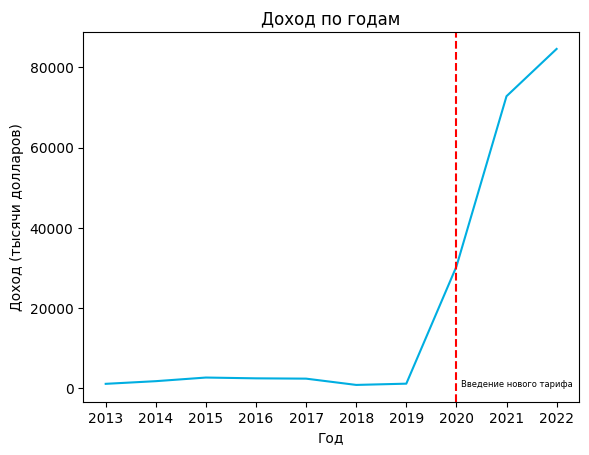

In [13]:
plt.plot(years[:-1], income[:-1], color="#00AEE1")
plt.title("Доход по годам")
plt.xlabel("Год")
plt.ylabel("Доход (тысячи долларов)")
plt.axvline(x=2020, color="r", linestyle="--")
plt.text(2020.1, 370, "Введение нового тарифа", fontsize=6)
plt.xticks(years[:-1])

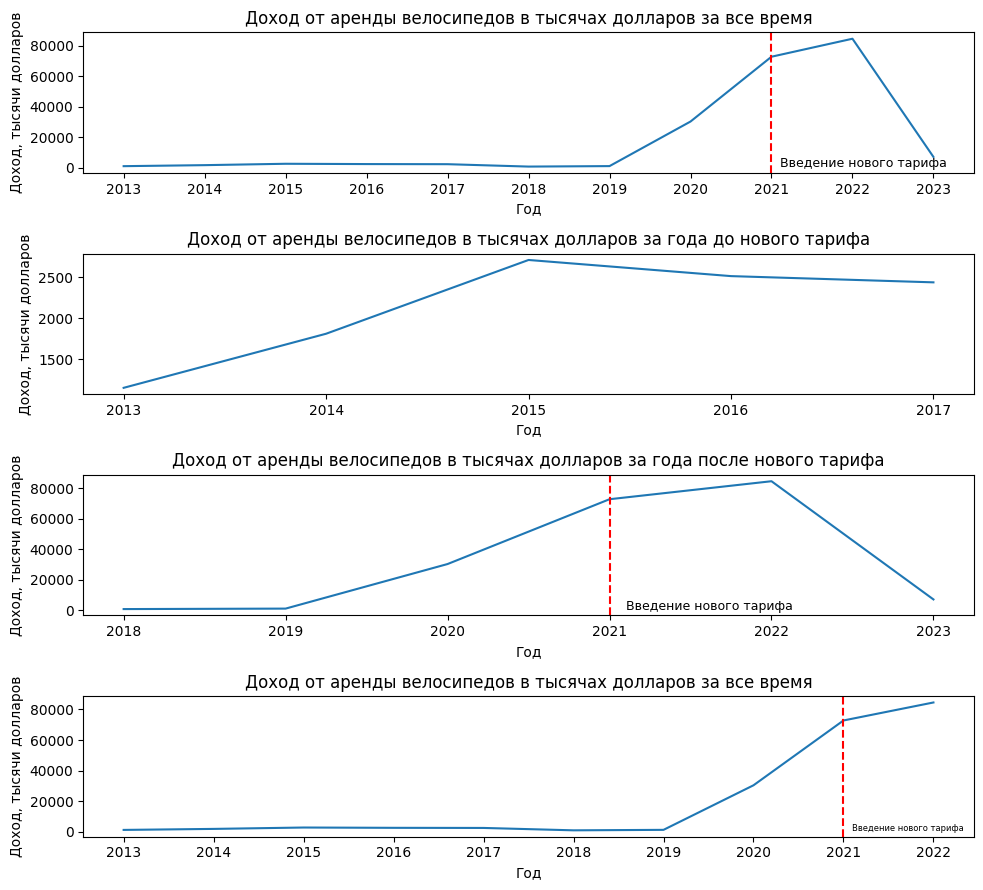

In [20]:
fig, axs = plt.subplots(4, 1, figsize=(10, 9))
axs[0].plot(years, income)
axs[0].set_title("Доход от аренды велосипедов в тысячах долларов за все время")
axs[0].set_xlabel("Год")
axs[0].set_ylabel("Доход, тысячи долларов")
axs[0].axvline(x=2021, color="r", linestyle="--")
axs[0].text(2021.1, 370, "Введение нового тарифа", fontsize=9)
axs[0].set_xticks(years)

axs[1].plot(years_with_first_formula, income_with_first_formula)
axs[1].set_title(
    "Доход от аренды велосипедов в тысячах долларов за года до нового тарифа"
)
axs[1].set_xlabel("Год")
axs[1].set_ylabel("Доход, тысячи долларов")
axs[1].set_xticks(years_with_first_formula)

axs[2].plot(years_with_second_formula, income_with_second_formula)
axs[2].set_title(
    "Доход от аренды велосипедов в тысячах долларов за года после нового тарифа"
)
axs[2].set_xlabel("Год")
axs[2].set_ylabel("Доход, тысячи долларов")
axs[2].set_xticks(years_with_second_formula)
axs[2].axvline(x=2021, color="r", linestyle="--")
axs[2].text(2021.1, 370, "Введение нового тарифа", fontsize=9)


axs[3].plot(years[:-1], income[:-1])
axs[3].set_title("Доход от аренды велосипедов в тысячах долларов за все время")
axs[3].set_xlabel("Год")
axs[3].set_ylabel("Доход, тысячи долларов")
axs[3].axvline(x=2021, color="r", linestyle="--")
axs[3].text(2021.1, 370, "Введение нового тарифа", fontsize=6)
axs[3].set_xticks(years[:-1])
plt.tight_layout()